# Motion Models
Source: Chapter 5 of Probabilistic Robotics.

## Introduction
We only focus in robots operating in planar environments.
We aim to describe a probabilistic model of kinematics, such that the outcome of a control is described by a posterior probability.
In practice, the exact shape of the model often seems less important that the fact that some provisions for uncertain outcomes are provided in the first place. In fact, many of the most successful models vastly overestimate the amount of uncertainty,


## Kinematic configuration
We define three important objects: the robot, the controls applied to the robot and the state of the robot.

In [1]:
import sys
import inspect
sys.path.append("../MotionModels")
import kinematics

sys.path.append("../2DProjectiveGeometry")
from math_utils import *

### State
The kinematic state of robots operating in planar environments can be summarized by three variables $(x, y, \theta)$ describing respectively the position in 2D and the angular orientation.
We decide that $\theta = 0$ means that the robot points in the direction of its x axis.

In general, we can see the state as the collection of all aspects of the robot (ie it's position, velocity, sensors states...) and its environment that can impact the future. It can be dynamic (ie position of people) or static (ie position of a wall).

A state is called complete if it is the best predictor of the future, in other words if it encompasses all the knowledge of previous states, motions, etc. In practice a state is never really complete.

In [2]:
print(inspect.getsource(kinematics.State))

class State:
    """
    State of a wheeled robot moving in 2D at a given time.
    """
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta

    def __repr__(self):
        return f"State [x = {self.x}, y = {self.y}, theta = {self.theta}]"

    def as_vector(self):
        return [self.x, self.y, self.theta]



### Motion / Controls
We consider two variables $(v, w)$ that are used to respectively control the translational and rotational velocity.

In [3]:
print(inspect.getsource(kinematics.Motion))

class Motion:
    """
    Defines the motion model at a given time.
    The motion model has two parameters: 
    - The transational velocity v
    - The roational velocity w
    """
    def __init__(self, v, w ):
        self.v = v
        self.w = w

    def __repr__(self):
        return f"Motion: [v = {self.v}, w = {self.w}"

    def as_vector(self):
        return [self.v, self.w]





### Robot
It is used to associate a state, a motion and a timestamp (and keep a history) as a single unit.

In [4]:
print(inspect.getsource(kinematics.Robot))

class Robot:
    def __init__(self, state: State, motion: Motion):
        # State and control of the robot at the 
        # current moment t
        self.states = [state]
        self.motion = motion
        # Motion error parameters
        self.alpha1 = 1
        self.alpha2 = 1
        self.alpha3 = 1
        self.alpha4 = 1
        self.alpha5 = 1
        self.alpha6 = 1

    def __repr__(self):
        return f"Robot: \nState: {self.get_curr_state()}"

    def push_new_state(self, new_state):
        self.states.append(new_state)

    def get_curr_state(self):
        return self.states[-1]

    def get_prev_state(self):
        return self.states[-2]

    def apply_control(self, ut):
        self.motion = ut

    def plot(self, ax):
        x = self.get_curr_state().x
        y = self.get_curr_state().y
        theta = self.get_curr_state().theta

        dx = 1
        dy = 0

        dx = dx * cos(theta) - dy * sin(theta)
        dy = dx * sin(theta) + dy * cos(theta)
       


## Probabilistic kinematics
The probabilistic kinematic model, or motion model, plays the role of the state estimation model in mobile robotics. This model is the conditional density $$p(x_t | u_t, x_{t-1})$$ where the $x_i$ are the robot poses and the $u_i$ are the motion commands.

We will describe two motion models:
- One assuming that the motion data $u_t$ specifies the velocity commands given to the robot's motors.
- One assuming that one is provided with odometry information.

In practice, odometry models tend to be more accurate than velocity models, for the simple reasons that most commercial robots do not execute velocity commands with the level of accuracy that can be obtained by measuring the rotation of the robot's wheels. However odometry data is only obtained after the fact, which means that it is not suitable for motion planning, such as obstacle avoidance.

# Velocity motion model
The velocity motion model assumes that we can control a robot through two velocities, a rotational and a translational velocity.

We denote the translational velocity at time $t$ by $v_t$ and the rotational velocity at time $t$ by $w_t$. Hence we have $u_t = [v_t, w_t]$.

## Closed form solution
We want to compute the probability $P(x_t | u_t, x_{t-1})$, ie the probability of a state given a control and a previous state, assuming that the control is carried out for a duration $\Delta t$. 
We have 6 motion error parameters parameters $\alpha_1$ to $\alpha_6$ that are specific to the robot and must be estimated.

- The proposed algorithm first calculates the controls of an error-free robot.
- Then the function $\textbf{prob(x,b)}$ models the motion error, ie it computes the probability of $x$ under a zero-centered variable with variance $b$.

In [8]:
from motionmodels import VelocityMotionModel, OdometryMotionModel
print(inspect.getsource(VelocityMotionModel))

class VelocityMotionModel(MotionModel):
    """
    Computes the probability of the robot's current state 
    given its motion and previous state.
    """
    def motion_model_velocity(self, robot: kinematics.Robot):
        state_curr = robot.get_curr_state()
        state_prev = robot.get_prev_state()
        ut = robot.motion

        xp, yp, thetap = state_curr.x, state_curr.y, state_curr.theta
        x, y, theta = state_prev.x, state_prev.y, state_prev.theta

        num_mu = (x - xp) * cos(theta) + (y - yp) * sin(theta)
        den_mu = (y - yp) * cos(theta) - (x - xp) * sin(theta)
        mu = 0.5 * (num_mu / den_mu)

        x_star = 0.5 * (x + xp) + mu * (y - yp)
        y_star = 0.5 * (y + yp) + mu * (xp - x)
        r_star = sqrt((x - x_star)**2 + (y - y_star)**2)

        delta_theta = atan2(yp - y_star, xp - x_star) - atan2(y - y_star, x - x_star)

        v_hat = (delta_theta / self.delta_time) * r_star
        w_hat = delta_theta / self.delta_time
        gamma_hat = (

In [9]:
""" 
Setup a test robot
In order to test, the robot needs:
- A previous state
- A motion control

We query then different hypothetic current states to get 
the probability of them
"""

prev_state = kinematics.State(x = 0, y = 0, theta = 0)
motion_control = kinematics.Motion(v = 1, w = 0)
myRobot = kinematics.Robot(state = prev_state, motion = motion_control) 
new_state = kinematics.State(x = 1, y = -0.1, theta = 0.2)
myRobot.push_new_state(new_state)

velocityModel = VelocityMotionModel()
velocityModel.motion_model_velocity(myRobot)

0.007675643875862971

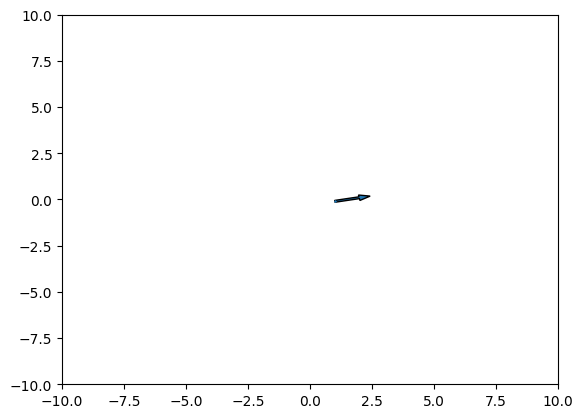

In [10]:
# Display the result for different states.
import matplotlib.pyplot as plt

study_square_area = 10
ax = plt.subplot()
plt.xlim(-study_square_area, study_square_area)
plt.ylim(-study_square_area, study_square_area)
myRobot.plot(ax)

In [11]:
# Sample motion model
def test_velocity_model(velocityModel):
    state = kinematics.State(x = 0, y = 0, theta = 0)
    motion_control = kinematics.Motion(v = 2, w = 0)
    myRobot = kinematics.Robot(state = state, motion = motion_control) 
    newstate = kinematics.State(x = 1, y = 0, theta = 0)
    myRobot.push_new_state(newstate)

    sampled_states = []
    for _ in range(50):
        sampled_states.append(velocityModel.sample_motion_model_velocity(myRobot))

    plt.figure()
    ax = plt.subplot()
    plt.scatter(x = [s.x for s in sampled_states], y = [s.y for s in sampled_states], s = 5, alpha = 0.5)
    plt.xlim(-study_square_area, study_square_area)
    plt.ylim(-study_square_area, study_square_area)
    myRobot.plot(ax)
    plt.show()


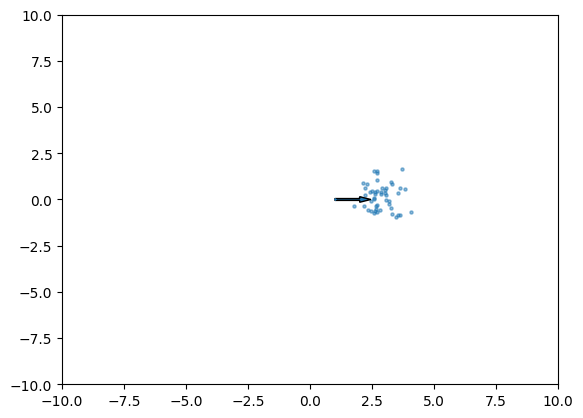

In [12]:
test_velocity_model(VelocityMotionModel())

# Odometry motion model 

In [15]:
print(inspect.getsource(OdometryMotionModel))

class OdometryMotionModel(MotionModel):
    def __init__(self):
        self.delta_time = 1
        self.distribution = [NormalDistribution, TriangularDistribution][0]()

    """
    Samples a new state x_t based on odometry information.
    The odometry information is given by looking at the current
    and previous state of the robot.
    """
    def sample_motion_model_velocity(self, robot: kinematics.Robot):
        state_curr = robot.get_curr_state()
        xp, yp, thetap = state_curr.x, state_curr.y, state_curr.theta

        state_prev = robot.get_prev_state()
        x, y, theta = state_prev.x, state_prev.y, state_prev.theta

        delta_rot_1 = atan2(yp - y, xp - x) - theta
        delta_trans = sqrt((x - xp)**2 + (y - yp)**2)
        delta_rot_2 = thetap - theta - delta_rot_1

        delta_rot_1_hat = delta_rot_1 - self.distribution.sample_probability(robot.alpha1 * delta_rot_1 + robot.alpha2 * delta_trans)
        delta_trans_hat = delta_trans - self.distribution.sample_

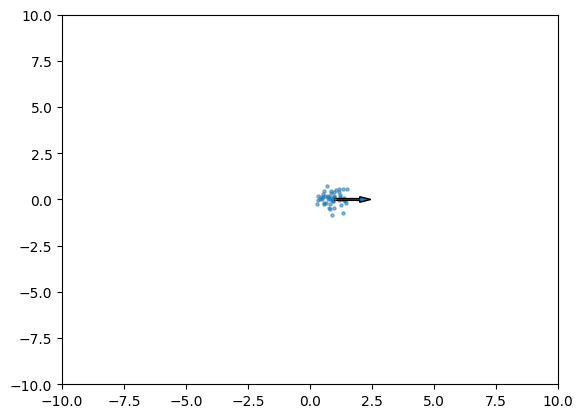

In [ ]:
"""
Remark: when testing her we actually move the robot in order to simulate odometry.
So we plot the robot after it actually moved.
The motion model aims to estimate that new position, so we expect to see points centered around 
the new robot location (which can be seen as a kind of ground truth)
"""
test_velocity_model(OdometryMotionModel())